## Key indicators as leading and lagging predictors
The first of these algorithms is a general exploration into how certain key variables perform for stock market movements as leading and lagging predictors across various time series. These indicators include:
- The The Volatility Index (VIX)
- Index moving averages (50, 100 and 200 days)
- Treasury rates (5, 10, 30)
- Relative Strength Index
- Put/Call Ratio

In [12]:
#import all libraries needed for analysis and investment metadata
import yfinance as yf
import pandas_datareader as pdr
import alpha_vantage as av
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [9]:
#define api key and timeseries for using alpha_vantage
api_key = 'ALUI1VJSESQR07TD'
ts = TimeSeries(key=api_key)
symbols=['QQQ', 'VXX']

#date range for filtered_date
start = '2009-01-30'
end = datetime.now().strftime('%Y-%m-%d')

df = pd.DataFrame()

#pull in daily prices for each symbol
for sym in symbols:
    data, meta_data = ts.get_daily(symbol=sym, outputsize='full')
    
    # Filter data for the specified date range
    filtered_data = {date: values['4. close'] for date, values in data.items() if start <= date <= end}
    
    # Convert filtered_data into a DataFrame
    sym_df = pd.DataFrame.from_dict(filtered_data, orient='index')
    sym_df.index = pd.to_datetime(sym_df.index)
    
    # Rename the column to use the symbol as the column header
    sym_df = sym_df.rename(columns={0: sym})
    
    # Concatenate the DataFrame for the current symbol to the main DataFrame
    df = pd.concat([df, sym_df], axis=1)

df.head(5)

,QQQ,VXX
2023-09-29,358.27,23.32
2023-09-28,358.01,22.87
2023-09-27,355.04,23.97
2023-09-26,354.21,25.04
2023-09-25,359.61,22.90


In [3]:
#calculate moving averages
sma = [50, 100, 200]

df_sma = df.sort_index(ascending=True) #make ascending to calc SMAs

#at each sma value, calculate the corresponding sma for each ticker
for num in sma:
    for sym in symbols:
        col_name = f'{sym}_SMA_{num}' #pass through column name for each sma
        df_sma[col_name] = df_sma[sym].rolling(window=num).mean()

df_sma = df_sma.sort_index(ascending=False)

#cut the number of rows equal to the highest sma value to have a full working set of data
df_sma.head(10)

,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200
2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075
2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525
2023-09-27,355.04,23.97,370.7622,23.2045,362.1598,26.77865,329.54420,26.457675
2023-09-26,354.21,25.04,371.3762,23.1947,361.7711,26.95955,329.18825,26.412725
2023-09-25,359.61,22.90,371.9442,23.1713,361.4019,27.11015,328.81985,26.363975
2023-09-22,357.91,22.87,372.3334,23.1917,360.9996,27.27005,328.43020,26.324825
2023-09-21,357.86,22.81,372.7582,23.2185,360.6424,27.41375,328.07885,26.283625
2023-09-20,364.54,21.18,373.0574,23.2437,360.2894,27.56425,327.75230,26.241475
2023-09-19,369.87,20.41,373.1300,23.3295,359.8475,27.74675,327.39820,26.208775
2023-09-18,370.66,20.51,373.0598,23.4345,359.2675,27.95485,327.01565,26.181325


In [4]:
#remove rows with NaN
df_sma_clean = df_sma.dropna()
df_sma_clean = df_sma_clean.reset_index()
df_sma_clean = df_sma_clean.rename(columns={'index': 'date'})
df_sma_clean['date'] = pd.to_datetime(df_sma_clean['date'])
df_sma_clean.head(5)

,date,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200
0,2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075
1,2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525
2,2023-09-27,355.04,23.97,370.7622,23.2045,362.1598,26.77865,329.54420,26.457675
3,2023-09-26,354.21,25.04,371.3762,23.1947,361.7711,26.95955,329.18825,26.412725
4,2023-09-25,359.61,22.90,371.9442,23.1713,361.4019,27.11015,328.81985,26.363975


In [4]:
#years to pull in historic treasury rates for
years = [2, 10, 30]

df_rate = pd.DataFrame()

#set up date column
url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=ALUI1VJSESQR07TD'
r = requests.get(url)
data = r.json()

for i in data['data']:
    df_rate = df_rate.append({'date': i['date']}, ignore_index=True)
    
#extract historic treasury rates reported daily
for year in years:
    url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity='+str(year)+'year&apikey=ALUI1VJSESQR07TD'
    r = requests.get(url)
    data = r.json()
    
    #populate rate
    for i in data['data']:
        df_rate.loc[df_rate['date'] == i['date'], str(year) +'yr_rate'] = i['value']
    
df_rate['date'] = pd.to_datetime(df_rate['date'])    
df_rate.head(10)

,date,2yr_rate,10yr_rate,30yr_rate
0,2023-09-28,5.04,4.59,4.71
1,2023-09-27,5.10,4.61,4.73
2,2023-09-26,5.04,4.56,4.70
3,2023-09-25,5.09,4.55,4.67
4,2023-09-22,5.10,4.44,4.53
5,2023-09-21,5.12,4.49,4.56
6,2023-09-20,5.12,4.35,4.40
7,2023-09-19,5.08,4.37,4.43
8,2023-09-18,5.05,4.32,4.40
9,2023-09-15,5.02,4.33,4.42


In [6]:
#Pull in Relative Strength Index
symbol = 'QQQ'

#set up date column
url = 'https://www.alphavantage.co/query?function=RSI&symbol='+symbol+'&interval=daily&time_period=10&series_type=open&apikey='+api_key
rsi_resp = requests.get(url)
rsi = json.loads(rsi_resp.content)

rsi_data = rsi['Technical Analysis: RSI']

df_rsi = pd.DataFrame([(date, rsi['RSI']) for date, rsi in rsi_data.items()], columns=['date', 'RSI'])
df_rsi['date'] = pd.to_datetime(df_rsi['date'])


df_rsi.head(5)

,date,RSI
0,2023-09-29,44.7898
1,2023-09-28,27.7772
2,2023-09-27,29.1595
3,2023-09-26,30.9147
4,2023-09-25,30.7749


## Further cleanup/data enhancements
### Categorical Field Additions
- Binary above or below SMAs
- General 30 day trend for rates (all)
- Flag for if rates are inverted
- 7 and 30 day trend for VXX

In [7]:
#above/below SMAs
df_sma_clean['QQQ'] = pd.to_numeric(df_sma_clean['QQQ'])
df_sma_clean['QQQ_SMA_50'] = pd.to_numeric(df_sma_clean['QQQ_SMA_50'])
df_sma_clean['QQQ_SMA_100'] = pd.to_numeric(df_sma_clean['QQQ_SMA_100'])
df_sma_clean['QQQ_SMA_200'] = pd.to_numeric(df_sma_clean['QQQ_SMA_200'])

df_sma_clean['Above_QQQ_SMA_50'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_50'] else 0, axis=1)
df_sma_clean['Above_QQQ_SMA_100'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_100'] else 0, axis=1)
df_sma_clean['Above_QQQ_SMA_200'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_200'] else 0, axis=1)

df_sma_clean.head(5)

,date,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200
0,2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075,0,0,1
1,2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525,0,0,1
2,2023-09-27,355.04,23.97,370.7622,23.2045,362.1598,26.77865,329.54420,26.457675,0,0,1
3,2023-09-26,354.21,25.04,371.3762,23.1947,361.7711,26.95955,329.18825,26.412725,0,0,1
4,2023-09-25,359.61,22.90,371.9442,23.1713,361.4019,27.11015,328.81985,26.363975,0,0,1


In [8]:
#vxx
df_sma_clean = df_sma_clean.sort_values(by='date', ascending=True)

#convert existing fields to numeric data
df_sma_clean['VXX'] = pd.to_numeric(df_sma_clean['VXX'])

# Calculate the 7-day rolling mean
df_sma_clean['VXX_7_mean'] = df_sma_clean['VXX'].rolling(window=7).mean()

# Create a new column for 7 days
df_sma_clean['VXX_7_rising'] = (df_sma_clean['VXX'] > df_sma_clean['VXX_7_mean']).astype(int)

# Calculate the 30-day rolling mean
df_sma_clean['VXX_30_mean'] = df_sma_clean['VXX'].rolling(window=30).mean()

# Create a new column 30 days
df_sma_clean['VXX_30_rising'] = (df_sma_clean['VXX'] > df_sma_clean['VXX_30_mean']).astype(int)

df_sma_clean = df_sma_clean.sort_values(by='date', ascending=False)
df_sma_clean.head(5)

,date,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_mean,VXX_7_rising,VXX_30_mean,VXX_30_rising
0,2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075,0,0,1,23.397143,0,22.502500,1
1,2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525,0,0,1,23.091429,0,22.604500,1
2,2023-09-27,355.04,23.97,370.7622,23.2045,362.1598,26.77865,329.54420,26.457675,0,0,1,22.740000,1,22.681167,1
3,2023-09-26,354.21,25.04,371.3762,23.1947,361.7711,26.95955,329.18825,26.412725,0,0,1,22.245714,1,22.707833,1
4,2023-09-25,359.61,22.90,371.9442,23.1713,361.4019,27.11015,328.81985,26.363975,0,0,1,21.622857,1,22.653833,1


In [9]:
#determine if rates are falling or rising
df_rate_clean = df_rate

df_rate_clean = df_rate_clean.sort_values(by='date', ascending=True)

df_rate_clean['2yr_rate'] = pd.to_numeric(df_rate_clean['2yr_rate'], errors='coerce', downcast='float')
df_rate_clean['10yr_rate'] = pd.to_numeric(df_rate_clean['10yr_rate'], errors='coerce', downcast='float')
df_rate_clean['30yr_rate'] = pd.to_numeric(df_rate_clean['30yr_rate'], errors='coerce', downcast='float')

df_rate_clean['rate_sum'] = df_rate_clean['2yr_rate'] + df_rate_clean['10yr_rate'] + df_rate_clean['30yr_rate']

df_rate_clean = df_rate_clean.dropna()

# Calculate the rolling means
df_rate_clean['rate_30_ave'] = df_rate_clean['rate_sum'].rolling(window=30).mean()

# Create a new column 30 days
df_rate_clean['rates_rising'] = (df_rate_clean['rate_sum'] > df_rate_clean['rate_30_ave']).astype(int)

df_rate_clean = df_rate_clean.sort_values(by='date', ascending=False)

df_rate_clean.head(5)

,date,2yr_rate,10yr_rate,30yr_rate,rate_sum,rate_30_ave,rates_rising
0,2023-09-28,5.04,4.59,4.71,14.340000,13.715333,1
1,2023-09-27,5.10,4.61,4.73,14.440001,13.691667,1
2,2023-09-26,5.04,4.56,4.70,14.300000,13.658667,1
3,2023-09-25,5.09,4.55,4.67,14.310000,13.630000,1
4,2023-09-22,5.10,4.44,4.53,14.070000,13.597000,1


In [10]:
#rsi cleanup
df_rsi_clean = df_rsi.sort_values(by='date', ascending=True)

#convert existing fields to numeric data
df_rsi_clean['RSI'] = pd.to_numeric(df_rsi_clean['RSI'])

# Calculate the 7-day rolling mean
df_rsi_clean['RSI_7_mean'] = df_rsi_clean['RSI'].rolling(window=7).mean()

# Create a new column for 7 days
df_rsi_clean['RSI_7_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_7_mean']).astype(int)

# Calculate the 30-day rolling mean
df_rsi_clean['RSI_30_mean'] = df_rsi_clean['RSI'].rolling(window=30).mean()

# Create a new column 30 days
df_rsi_clean['RSI_30_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_30_mean']).astype(int)

df_rsi_clean = df_rsi_clean.sort_values(by='date', ascending=False)
df_rsi_clean.head(5)

,date,RSI,RSI_7_mean,RSI_7_rising,RSI_30_mean,RSI_30_rising
0,2023-09-29,44.7898,33.095371,1,46.148910,0
1,2023-09-28,27.7772,33.602543,0,45.805947,0
2,2023-09-27,29.1595,36.097000,0,46.118973,0
3,2023-09-26,30.9147,38.393986,0,46.566367,0
4,2023-09-25,30.7749,41.862071,0,46.623820,0


## Prepare DataFrames for Analysis
### Two separate tables
- Discrete variables (1s and 0s)
- Continuous variables
- Add columns for 1, 3, 5, 7, 15, 30, 60, 90 day performance

In [63]:
#create discrete and continuous tables
df_discrete = df_sma_clean[['date', 'QQQ', 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_rising', 'VXX_30_rising']]
df_discrete = df_discrete.merge(df_rate_clean[['date', 'rates_rising']], on='date')
df_discrete = df_discrete.merge(df_rsi_clean[['date', 'RSI_7_rising', 'RSI_30_rising']], on='date')

df_continuous = df_sma_clean[['date', 'QQQ', 'QQQ_SMA_50', 'QQQ_SMA_100', 'QQQ_SMA_200', 'VXX_SMA_50', 'VXX_SMA_100', 'VXX_SMA_200']]
df_continuous = df_continuous.merge(df_rate_clean[['date', 'rate_sum']], on='date')
df_continuous = df_continuous.merge(df_rsi_clean[['date', 'RSI_7_mean', 'RSI_30_mean']], on='date')

In [96]:
#add columns to each new dataframe for performance over certain periods
periods = [1, 3, 5, 7, 15, 30, 60, 90]

#create new fields for discrete and continuous tables to show performance in future for each period
for period in periods:
    df_discrete[str(period)+'_day'] = (df_discrete['QQQ'].shift(period) > df_discrete['QQQ']).astype(int)
    df_continuous[str(period)+'_day'] = (df_continuous['QQQ'].shift(period)/df_discrete['QQQ'])
    

In [69]:
df_discrete.head(5)

,date,QQQ,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_rising,VXX_30_rising,rates_rising,RSI_7_rising,RSI_30_rising,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-09-28,358.01,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
1,2023-09-27,355.04,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0
2,2023-09-26,354.21,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0
3,2023-09-25,359.61,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,2023-09-22,357.91,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0


In [97]:
df_continuous.head(5)

,date,QQQ,QQQ_SMA_50,QQQ_SMA_100,QQQ_SMA_200,VXX_SMA_50,VXX_SMA_100,VXX_SMA_200,rate_sum,RSI_7_mean,RSI_30_mean,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-09-28,358.01,370.2094,362.5110,329.92405,23.1839,26.61985,26.495525,14.340000,33.602543,45.805947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-27,355.04,370.7622,362.1598,329.54420,23.2045,26.77865,26.457675,14.440001,36.097000,46.118973,1.008365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-26,354.21,371.3762,361.7711,329.18825,23.1947,26.95955,26.412725,14.300000,38.393986,46.566367,1.002343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-25,359.61,371.9442,361.4019,328.81985,23.1713,27.11015,26.363975,14.310000,41.862071,46.623820,0.984984,0.995551,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-22,357.91,372.3334,360.9996,328.43020,23.1917,27.27005,26.324825,14.070000,45.370814,46.710643,1.004750,0.991981,NaN,NaN,NaN,NaN,NaN,NaN


## Main Function
Puts all of the above steps together for a seamless execution and returns the two cleaned data frames

In [2]:
def rates():

    #years to pull in historic treasury rates for
    years = [2, 10, 30]

    df_rate = pd.DataFrame()

    #set up date column
    url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=ALUI1VJSESQR07TD'
    r = requests.get(url)
    data = r.json()

    for i in data['data']:
        df_rate = df_rate.append({'date': i['date']}, ignore_index=True)

    #extract historic treasury rates reported daily
    for year in years:
        url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity='+str(year)+'year&apikey=ALUI1VJSESQR07TD'
        r = requests.get(url)
        data = r.json()

        #populate rate
        for i in data['data']:
            df_rate.loc[df_rate['date'] == i['date'], str(year) +'yr_rate'] = i['value']

    df_rate['date'] = pd.to_datetime(df_rate['date']) 
    
    return df_rate

In [3]:
def data_compilation(symbols):
    api_key = 'ALUI1VJSESQR07TD'
    ts = TimeSeries(key=api_key)
    #symbols=['QQQ', 'VXX']

    #date range for filtered_date
    start = '2009-01-30'
    end = datetime.now().strftime('%Y-%m-%d')

    df = pd.DataFrame()

    #pull in daily prices for each symbol
    for sym in symbols:
        data, meta_data = ts.get_daily(symbol=sym, outputsize='full')

        # Filter data for the specified date range
        filtered_data = {date: values['4. close'] for date, values in data.items() if start <= date <= end}

        # Convert filtered_data into a DataFrame
        sym_df = pd.DataFrame.from_dict(filtered_data, orient='index')
        sym_df.index = pd.to_datetime(sym_df.index)

        # Rename the column to use the symbol as the column header
        sym_df = sym_df.rename(columns={0: sym})

        # Concatenate the DataFrame for the current symbol to the main DataFrame
        df = pd.concat([df, sym_df], axis=1)

    #calculate moving averages
    sma = [50, 100, 200]

    df_sma = df.sort_index(ascending=True) #make ascending to calc SMAs

    #at each sma value, calculate the corresponding sma for each ticker
    for num in sma:
        for sym in symbols:
            col_name = f'{sym}_SMA_{num}' #pass through column name for each sma
            df_sma[col_name] = df_sma[sym].rolling(window=num).mean()

    df_sma = df_sma.sort_index(ascending=False)
    
    #remove rows with NaN
    df_sma_clean = df_sma.dropna()
    df_sma_clean = df_sma_clean.reset_index()
    df_sma_clean = df_sma_clean.rename(columns={'index': 'date'})
    df_sma_clean['date'] = pd.to_datetime(df_sma_clean['date'])
    
    #run rates function
    df_rate = rates()
    
    #Pull in Relative Strength Index
    symbol = symbols[0]

    #set up date column
    url = 'https://www.alphavantage.co/query?function=RSI&symbol='+symbol+'&interval=daily&time_period=10&series_type=open&apikey='+api_key
    rsi_resp = requests.get(url)
    rsi = json.loads(rsi_resp.content)

    rsi_data = rsi['Technical Analysis: RSI']

    df_rsi = pd.DataFrame([(date, rsi['RSI']) for date, rsi in rsi_data.items()], columns=['date', 'RSI'])
    df_rsi['date'] = pd.to_datetime(df_rsi['date'])
    
    #above/below SMAs
    df_sma_clean['QQQ'] = pd.to_numeric(df_sma_clean['QQQ'])
    df_sma_clean['QQQ_SMA_50'] = pd.to_numeric(df_sma_clean['QQQ_SMA_50'])
    df_sma_clean['QQQ_SMA_100'] = pd.to_numeric(df_sma_clean['QQQ_SMA_100'])
    df_sma_clean['QQQ_SMA_200'] = pd.to_numeric(df_sma_clean['QQQ_SMA_200'])

    df_sma_clean['Above_QQQ_SMA_50'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_50'] else 0, axis=1)
    df_sma_clean['Above_QQQ_SMA_100'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_100'] else 0, axis=1)
    df_sma_clean['Above_QQQ_SMA_200'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_200'] else 0, axis=1)

    #vxx
    df_sma_clean = df_sma_clean.sort_values(by='date', ascending=True)

    #convert existing fields to numeric data
    df_sma_clean['VXX'] = pd.to_numeric(df_sma_clean['VXX'])

    # Calculate the 7-day rolling mean
    df_sma_clean['VXX_7_mean'] = df_sma_clean['VXX'].rolling(window=7).mean()

    # Create a new column for 7 days
    df_sma_clean['VXX_7_rising'] = (df_sma_clean['VXX'] > df_sma_clean['VXX_7_mean']).astype(int)

    # Calculate the 30-day rolling mean
    df_sma_clean['VXX_30_mean'] = df_sma_clean['VXX'].rolling(window=30).mean()

    # Create a new column 30 days
    df_sma_clean['VXX_30_rising'] = (df_sma_clean['VXX'] > df_sma_clean['VXX_30_mean']).astype(int)

    df_sma_clean = df_sma_clean.sort_values(by='date', ascending=False)
    
    #determine if rates are falling or rising
    df_rate_clean = df_rate

    df_rate_clean = df_rate_clean.sort_values(by='date', ascending=True)

    df_rate_clean['2yr_rate'] = pd.to_numeric(df_rate_clean['2yr_rate'], errors='coerce', downcast='float')
    df_rate_clean['10yr_rate'] = pd.to_numeric(df_rate_clean['10yr_rate'], errors='coerce', downcast='float')
    df_rate_clean['30yr_rate'] = pd.to_numeric(df_rate_clean['30yr_rate'], errors='coerce', downcast='float')

    df_rate_clean['rate_sum'] = df_rate_clean['2yr_rate'] + df_rate_clean['10yr_rate'] + df_rate_clean['30yr_rate']

    df_rate_clean = df_rate_clean.dropna()

    # Calculate the rolling means
    df_rate_clean['rate_30_ave'] = df_rate_clean['rate_sum'].rolling(window=30).mean()

    # Create a new column 30 days
    df_rate_clean['rates_rising'] = (df_rate_clean['rate_sum'] > df_rate_clean['rate_30_ave']).astype(int)

    df_rate_clean = df_rate_clean.sort_values(by='date', ascending=False)
    
    #rsi cleanup
    df_rsi_clean = df_rsi.sort_values(by='date', ascending=True)

    #convert existing fields to numeric data
    df_rsi_clean['RSI'] = pd.to_numeric(df_rsi_clean['RSI'])

    # Calculate the 7-day rolling mean
    df_rsi_clean['RSI_7_mean'] = df_rsi_clean['RSI'].rolling(window=7).mean()

    # Create a new column for 7 days
    df_rsi_clean['RSI_7_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_7_mean']).astype(int)

    # Calculate the 30-day rolling mean
    df_rsi_clean['RSI_30_mean'] = df_rsi_clean['RSI'].rolling(window=30).mean()

    # Create a new column 30 days
    df_rsi_clean['RSI_30_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_30_mean']).astype(int)

    df_rsi_clean = df_rsi_clean.sort_values(by='date', ascending=False) 

    #create discrete and continuous tables
    df_discrete = df_sma_clean[['date', 'QQQ', 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_rising', 'VXX_30_rising']]
    df_discrete = df_discrete.merge(df_rate_clean[['date', 'rates_rising']], on='date')
    df_discrete = df_discrete.merge(df_rsi_clean[['date', 'RSI_7_rising', 'RSI_30_rising']], on='date')

    df_continuous = df_sma_clean[['date', 'QQQ', 'QQQ_SMA_50', 'QQQ_SMA_100', 'QQQ_SMA_200', 'VXX_SMA_50', 'VXX_SMA_100', 'VXX_SMA_200']]
    df_continuous = df_continuous.merge(df_rate_clean[['date', 'rate_sum']], on='date')
    df_continuous = df_continuous.merge(df_rsi_clean[['date', 'RSI_7_mean', 'RSI_30_mean']], on='date')
    
    #add columns to each new dataframe for performance over certain periods
    periods = [1, 3, 5, 7, 15, 30, 60, 90]

    #create new fields for discrete and continuous tables to show performance in future for each period
    for period in periods:
        df_discrete[str(period)+'_day'] = (df_discrete['QQQ'].shift(period) > df_discrete['QQQ']).astype(int)
        df_continuous[str(period)+'_day'] = (df_continuous['QQQ'].shift(period)/df_discrete['QQQ'])
        
    return df_discrete, df_continuous

In [4]:
#change symbols you want to run analysis for
symbols=['QQQ', 'VXX']

#Run through data_compilation function and return a discrete and continous dataframe
df_discrete, df_continuous = data_compilation(symbols)

# Start Analysis
- Test predictability of each variable
- Narrow down to most explanatory 
- Develop ML model

In [8]:
df_discrete.head(5)

,date,QQQ,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_rising,VXX_30_rising,rates_rising,RSI_7_rising,RSI_30_rising,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-09-28,358.01,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
1,2023-09-27,355.04,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0
2,2023-09-26,354.21,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0
3,2023-09-25,359.61,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,2023-09-22,357.91,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0


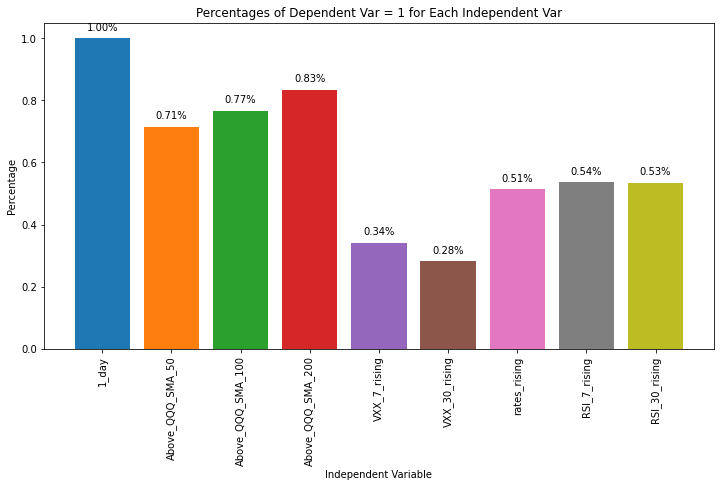

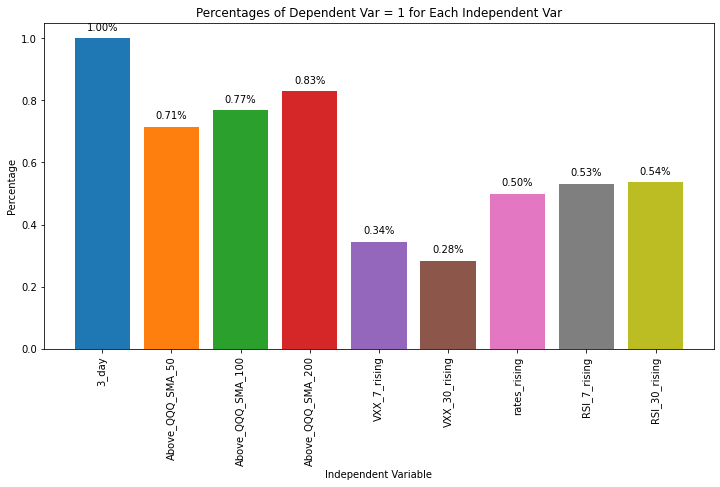

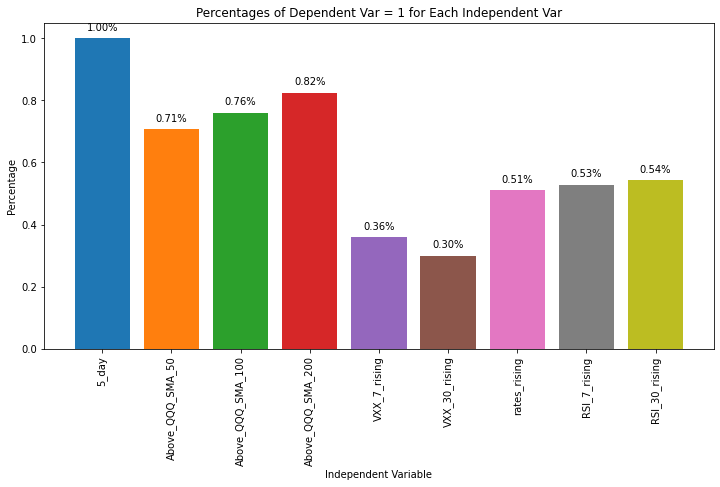

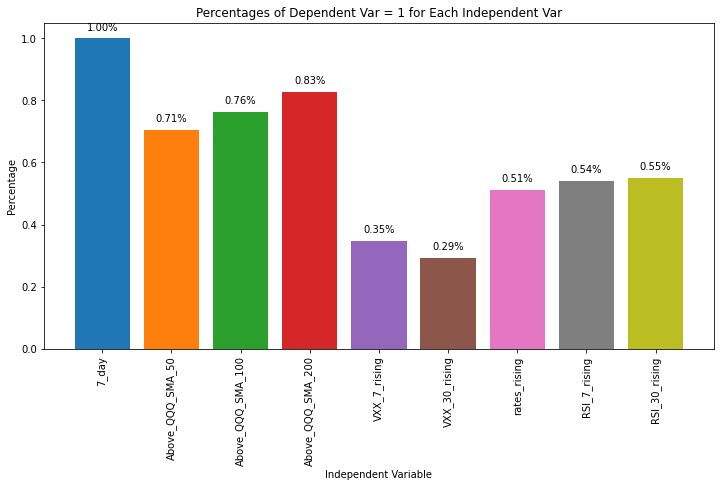

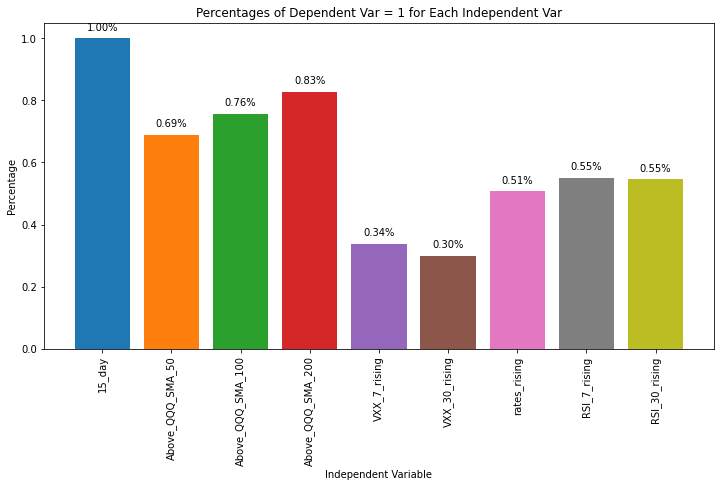

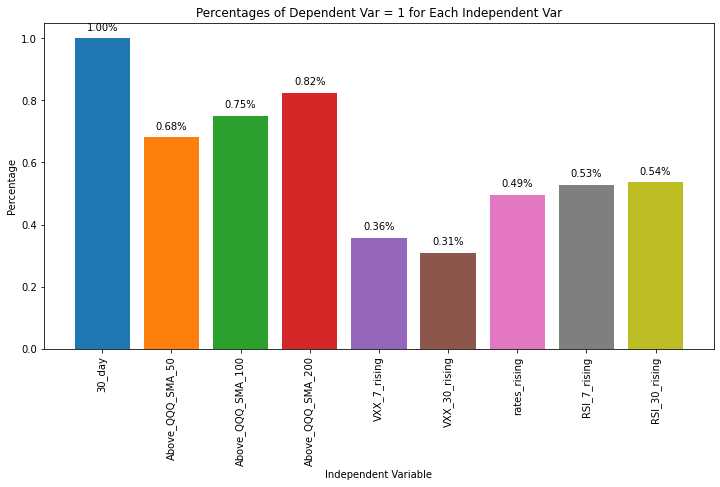

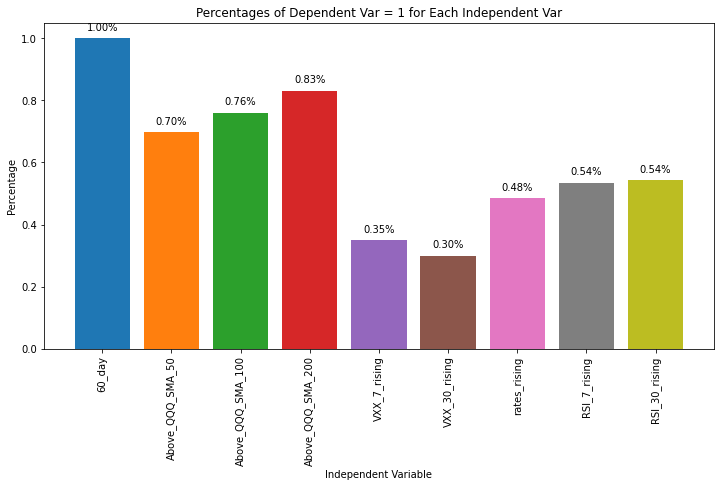

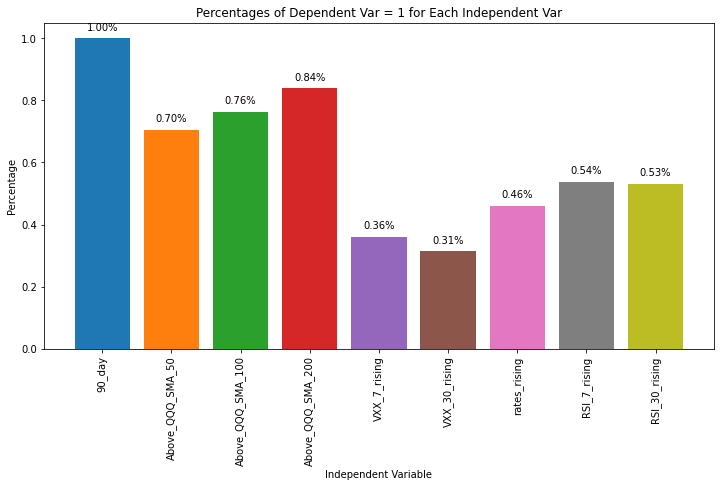

In [25]:
days = ['1_day', '3_day', '5_day', '7_day', '15_day', '30_day', '60_day', '90_day']

for day in days:

    # Create a list of independent variable column names
    independent_vars = [day, 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_rising', 'VXX_30_rising', 'rates_rising', 'RSI_7_rising', 'RSI_30_rising']

    # Create a dictionary to store the counts of dependent variable = 1 for each independent variable
    count_dict = {}
    for col in independent_vars:
        count_dict[col] = 0

    # Iterate through the dataframe and increment the count for each independent variable
    for index, row in df_discrete.iterrows():
        for col in independent_vars:
            if row[col] == 1 and row[day] == 1:
                count_dict[col] += 1

    # Create a dictionary to store the percentages of dependent variable = 1 for each independent variable
    percent_dict = {}
    for col, count in count_dict.items():
        percent_dict[col] = count / (df_discrete[day] == 1).sum()

    # Create a bar chart of the percentages
    plt.figure(figsize=(12, 6))
    for col, percent in percent_dict.items():
        plt.bar(col, percent)

        # Add label above each bar graph with the value of the percentage
        plt.text(col, percent + 0.02, f'{percent:.2f}%', ha='center', va='bottom')

    plt.title('Percentages of Dependent Var = 1 for Each Independent Var')
    plt.xlabel('Independent Variable')
    plt.ylabel('Percentage')
    plt.xticks(rotation=90)
    plt.show()